<a href="https://colab.research.google.com/github/HeshanNavindu-7/oilspill-detection/blob/main/oilspill_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install opendatasets


In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/saanvitayal07/oil-spill-and-no-oil-spill")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heshannavindu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/saanvitayal07/oil-spill-and-no-oil-spill


100%|██████████| 26.5M/26.5M [00:02<00:00, 10.5MB/s]


In [4]:
import os
import random
import matplotlib.pyplot as plt
import cv2

#define path
dataset_dir="/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix"
class_count={}
for detection_class in os.listdir(dataset_dir):
  print(detection_class)
  class_dir= os.path.join(dataset_dir,detection_class)
  if os.path.isdir(class_dir):
    num_images=len(os.listdir(class_dir))
    class_count[detection_class]=num_images




train
test


Train Data


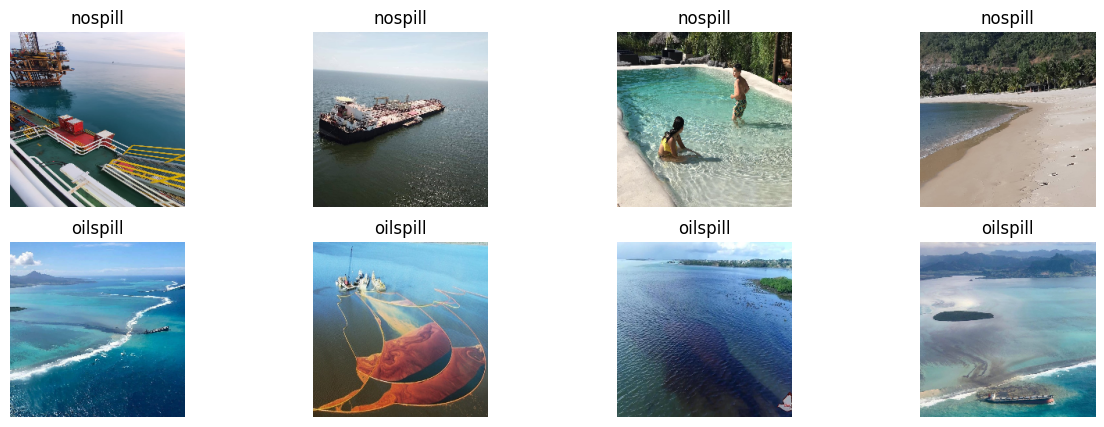

Test Data


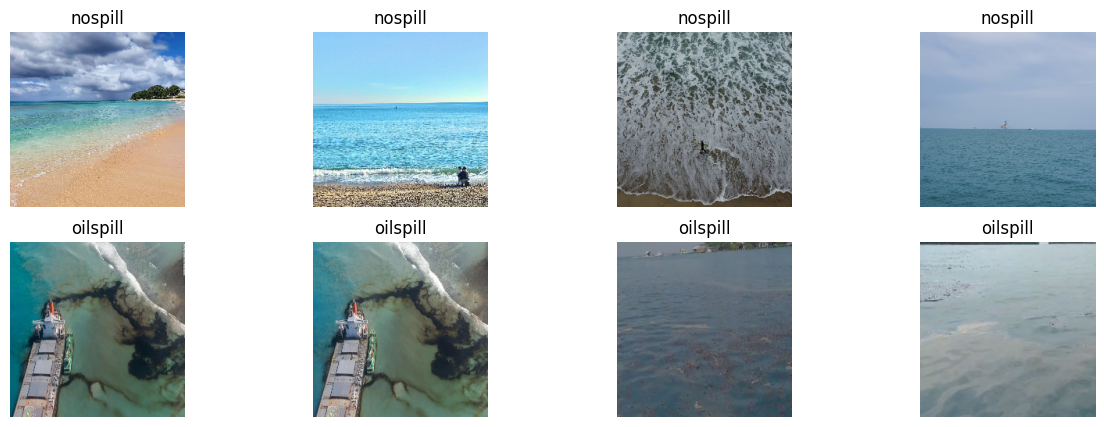

In [8]:

# Define path
dataset_dir = "/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix"
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Define image size and batch size
target_size = (224, 224)
batch_size = 32

# Display sample data
def display_sample(directory, num_samples=4):
    classes = ['nospill', 'oilspill']
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        for j, filename in enumerate(os.listdir(class_dir)):
            if j >= num_samples:
                break
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, target_size)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(class_name)
    plt.show()

print("Train Data")
display_sample(train_dir)
print("Test Data")
display_sample(test_dir)


In [7]:
# Define directories (adjust these paths to your setup)
train_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/train'
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'

In [23]:
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Create data generators with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of training data for validation
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 159 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


In [24]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load the InceptionV3 model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Print the model summary
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


87910968/87910968 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_8 (Bat  (None, 111, 111, 32)         96        ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)   

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
4/4 [==============================] - 31s 6s/step - loss: 18.2527 - accuracy: 0.4409 - val_loss: 13.6402 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 28s 8s/step - loss: 13.9090 - accuracy: 0.4882 - val_loss: 12.5791 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 28s 8s/step - loss: 12.2744 - accuracy: 0.6797 - val_loss: 11.5853 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 28s 8s/step - loss: 11.2654 - accuracy: 0.7008 - val_loss: 10.7113 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 28s 8s/step - loss: 10.3936 - accuracy: 0.6457 - val_loss: 9.7615 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 28s 8s/step - loss: 9.4435 - accuracy: 0.8031 - val_loss: 8.9653 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 7/50
4/4 [==============================] - 30s 8s/step - loss: 8.6535 - accura

In [26]:
# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
4/4 [==============================] - 36s 7s/step - loss: 0.7081 - accuracy: 0.9685 - val_loss: 0.6763 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 2/50
4/4 [==============================] - 31s 8s/step - loss: 0.7056 - accuracy: 0.8898 - val_loss: 0.5650 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 3/50
4/4 [==============================] - 27s 7s/step - loss: 0.6437 - accuracy: 0.9219 - val_loss: 0.6390 - val_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 4/50
4/4 [==============================] - 26s 6s/step - loss: 0.5631 - accuracy: 0.9609 - val_loss: 0.8689 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 5/50
4/4 [==============================] - 26s 6s/step - loss: 0.5463 - accuracy: 0.9528 - val_loss: 0.8858 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 6/50
4/4 [==============================] - 29s 7s/step - loss: 0.5093 - accuracy: 0.9688 - val_loss: 0.8367 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 7/50
4/4 [==============================] - 27s 7s/step - loss: 

Found 49 images belonging to 2 classes.
2/2 [==============================] - 7s 3s/step - loss: 1.0365 - accuracy: 0.7959
Test Loss: 1.0364859104156494
Test Accuracy: 0.795918345451355


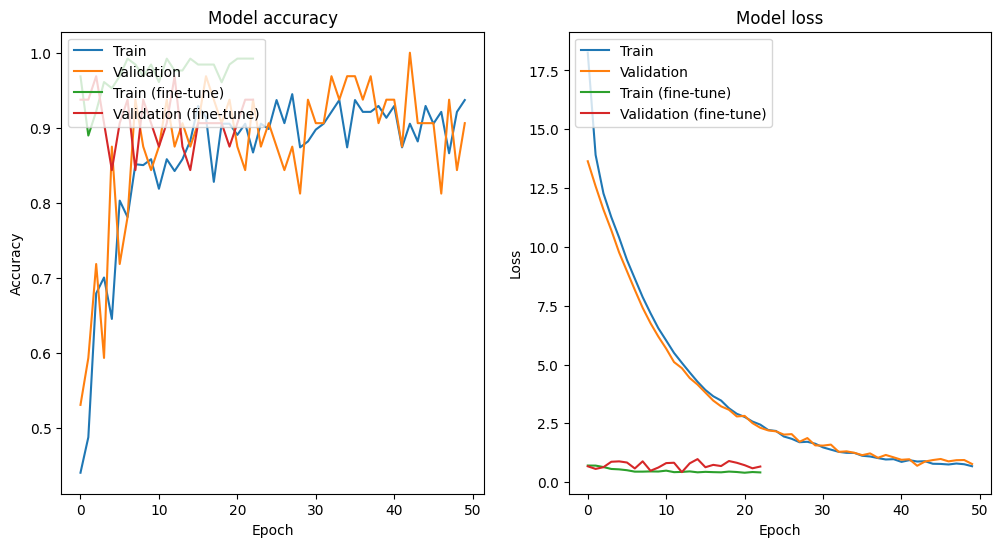

In [28]:
# Define the test data generator
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Train (fine-tune)', 'Validation (fine-tune)'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Train (fine-tune)', 'Validation (fine-tune)'], loc='upper left')

plt.show()
